# **Analysis of models trained on MNIST classification**
Author: patrick.mccarthy@dtc.ox.ac.uk

In [1]:
from pathlib import Path
import pickle
import glob
import os
import copy
import traceback

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colormaps as cm
from scipy.special import softmax
from scipy.linalg import svd
from sklearn import svm
from sklearn.decomposition import KernelPCA, PCA
from scipy.stats import entropy

from thalamocortex.models import CTCNet
from thalamocortex.utils import create_data_loaders, activation_hook, get_neuron_weights, plot_receptive_field

/Users/patmccarthy/miniconda3/envs/thalamocortex/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['legend.fontsize'] = 8  
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['axes.facecolor'] = 'w'  
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['savefig.bbox'] = 'tight'  
plt.rcParams['savefig.pad_inches'] = 0.1 
plt.rcParams['axes.titlesize'] = 10  
plt.rcParams['figure.titlesize'] = 10  

In [3]:
save_path = "/Users/patmccarthy/Documents/phd/rotation1/results_11_03_25/mnist"

### **Load results**

In [4]:
results_paths = {
    "no feedback": "/Users/patmccarthy/Documents/thalamocortex/results/06_03_25_feedforward_mnist/0_CTCNet_TC_none",
    "driver": "/Users/patmccarthy/Documents/thalamocortex/results/11_03_25_driver_mnist/0_CTCNet_TC_add_reciprocal_readout",
    "modulator": "/Users/patmccarthy/Documents/thalamocortex/results/11_03_25_mod1_mnist/0_CTCNet_TC_multi_pre_activation_reciprocal",
    # "mod2": "/Users/patmccarthy/Documents/thalamocortex/results/11_03_25_mod2_mnist/...",
}

In [8]:
# load models, learning stats, results 
results = {}
for model_name, path in results_paths.items():
    
    # NOTE: note loading trained models because can instantiate from final weights

    # hyperparameters
    with open(Path(f"{path}", "hyperparams.pkl"), "rb") as handle:
        hp = pickle.load(handle)

    # learning progress
    with open(Path(f"{path}", "learning.pkl"), "rb") as handle:
        learning = pickle.load(handle)

    # store results and params in dict 
    results[model_name] = {"val_losses": learning["val_losses"],
                           "train_losses": learning["train_losses"],
                           "val_topk_accs": learning["val_topk_accs"],
                           "train_topk_accs": learning["train_topk_accs"],
                           "train_time": learning["train_time"],
                           "state_dicts": learning["state_dicts"],
                           "hyperparams": hp}
    
    # get number of epochs to train for
    n_epochs = len(learning["train_topk_accs"])

    if model_name in ["driver", "modulator"]:
        results[model_name]["val_losses"].pop(0)
        results[model_name]["val_topk_accs"].pop(0)
        results[model_name]["state_dicts"].pop(0)

    else:
        epoch_range = np.arange(0, n_epochs)

    # get top-1 accuracies in more convenient form for plotting
    train_top1_accs = []
    # val_top1_accs = []

    # store training info
    for epoch in np.arange(n_epochs):
        train_top1_accs.append(learning["train_topk_accs"][epoch][1])
        # val_top1_accs.append(learning["val_topk_accs"][epoch][1])
    results[model_name]["train_top1_accs"] = np.array(train_top1_accs)
    # results[model_name]["val_top1_accs"] = np.array(val_top1_accs)
    

FileNotFoundError: [Errno 2] No such file or directory: '/Users/patmccarthy/Documents/thalamocortex/results/06_03_25_feedforward_mnist/0_CTCNet_TC_none/learning.pkl'

### **Learning progress**

In [6]:
model_plot_list = ["no feedback", "driver", "modulator"]

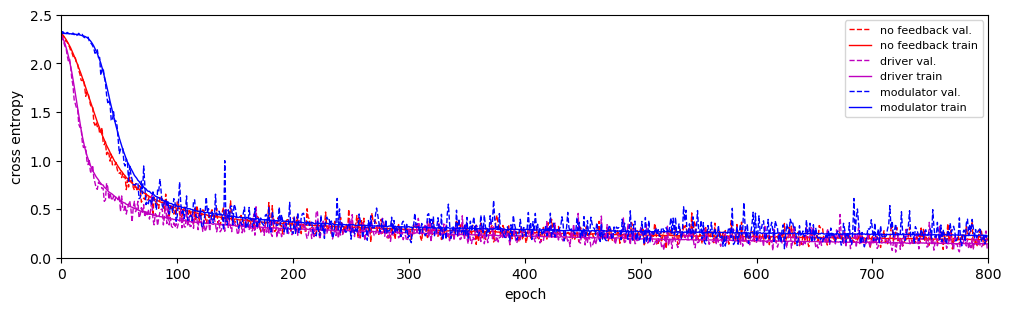

In [7]:
# loss through time
n_epochs = len(results[model_plot_list[0]]["val_losses"])
colours = ["r", "m", "b", "o"]
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
models_plotted = []
models_plotted_idx = 0
for _, (model_name, model_results) in enumerate(results.items()):
    if model_name in model_plot_list:
        models_plotted.append(model_name)
        models_plotted_idx += 1

        n_epochs = len(model_results["val_losses"])

        ax.plot(np.arange(n_epochs), np.median(np.array(model_results["val_losses"]), axis=-1), ls="--", linewidth=1, label=f"{model_name} val.", c=colours[models_plotted_idx-1])
        ax.plot(np.arange(n_epochs), np.median(np.array(model_results["train_losses"]), axis=-1), ls="-", linewidth=1, label=f"{model_name} train", c=colours[models_plotted_idx-1])

# ax.set_xticks(range(1, len(models_plotted)+1), models_plotted)
ax.set_ylabel("cross entropy")
ax.set_xlabel("epoch")
ax.set_xlim(0, n_epochs)
ax.set_ylim(0, 2.5)
ax.legend(loc="upper right")

In [6]:
# accuracy through time
n_epochs = len(results[model_plot_list[0]]["val_losses"])
fig, ax = plt.subplots(1, 1, figsize=(10, 3), layout="constrained")
ax.axhline(10, ls="--", c="k", label="chance")
models_plotted = []
models_plotted_idx = 0
for _, (model_name, model_results) in enumerate(results.items()):
    if model_name in model_plot_list:
        models_plotted.append(model_name)
        models_plotted_idx += 1

        n_epochs = len(model_results["val_losses"])

        # ax.plot(np.arange(n_epochs), np.array(model_results["val_top1_accs"]),ls="--", label=f"{model_name} val.", linewidth=1, c=colours[models_plotted_idx-1])
        ax.plot(np.arange(n_epochs), np.array(model_results["train_top1_accs"]) * 100, ls="-", label=f"{model_name} train", linewidth=1, c=colours[models_plotted_idx-1])

# ax.set_xticks(range(1, len(models_plotted)+1), models_plotted)
ax.set_ylabel("top-1 accuracy (%)")
ax.set_xlabel("epoch")
ax.set_ylim(0, 100)
ax.set_xlim(0, n_epochs)
ax.legend(loc="center right")

NameError: name 'model_plot_list' is not defined

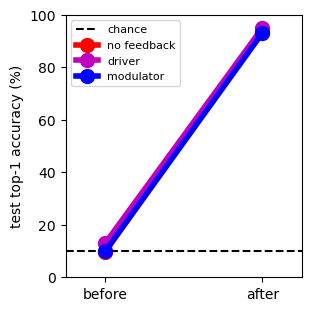

In [9]:
# accuracy before and after convergence
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.axhline(10, ls="--", c="k", label="chance")
for models_plotted_idx, (model_name, model_results) in enumerate(results.items()):
    # print(f"{models_plotted_idx}")
    if model_name in model_plot_list:
        ax.plot([0, 1], [model_results["train_top1_accs"][0] * 100, model_results["train_top1_accs"][-1] * 100], c=colours[models_plotted_idx], marker="o", markersize=10, linewidth=4, label=model_name)
ax.set_ylabel("test top-1 accuracy (%)")
ax.set_ylim(0, 100)
ax.set_xlim(-0.25, 1.25)
ax.set_xticks([0, 1])
ax.set_xticklabels(["before", "after"])
ax.legend(loc="upper left")
fig.savefig(Path(save_path, "accuracy_prepostlearning.png"))

### **Trained model analysis**

In [10]:
models_selected = ["no feedback", "driver", "modulator"]

In [11]:
# epoch of trained model weights to use 
epoch_trained = 800

Test set inference

In [12]:
# create loaders
trainset_loader, testset_loader, metadata = create_data_loaders(dataset=results[models_selected[0]]["hyperparams"]["dataset"],
                                                                norm=results[models_selected[0]]["hyperparams"]["norm"],
                                                                batch_size=32,
                                                                save_path="/Users/patmccarthy/Documents/ThalamoCortex/data")


In [13]:
# load full test set
X_all = []
y_all = []
for X, y in iter(testset_loader):
    # X_all.append(X.detach().numpy()[:, 0, :, :])
    # y_all.append(y.detach().numpy()[:])
    X_all.append(X[:, :, :])
    y_all.append(y[:])
if results[models_selected[0]]["hyperparams"]["dataset"] in ["BinaryMNIST", "LeftRightMNIST"]:
    # Concatenate along the first axis (num_samples)
    X_all_arr = np.concatenate(X_all, axis=0)  # Shape: (num_samples, 1, 28, 28)
    y_all_reshaped = np.concatenate(y_all, axis=0)  # Shape: (num_samples,)

    # Reshape X to [samples, features]
    X_all_reshaped = X_all_arr.reshape(X_all_arr.shape[0], -1)  # Shape: (num_samples, 28*28)
else:
    X_all_tensor = torch.cat(X_all, dim=0)  # Shape: [num_samples, 1, 28, 28]
    y_all_tensor = torch.cat(y_all, dim=0)  # Shape: [num_samples]

    # Convert to NumPy
    X_all_arr = X_all_tensor.numpy()  # Shape: (num_samples, 1, 28, 28)
    y_all_reshaped = y_all_tensor.numpy()  # Shape: (num_samples,)

    # Reshape X to [samples, features]
    X_all_reshaped = X_all_arr.reshape(X_all_arr.shape[0], -1)  # Shape: (num_samples, 28*28)

In [14]:
# inference on full test set using models trained to various epochs
epochs_range = np.arange(0, 800, 25)
epochs_range = np.append(epochs_range, [799])
activations = {}
for model_selected in models_selected:
    activations[model_selected] = {}

    # instantiate model
    model = CTCNet(input_size=results[model_selected]["hyperparams"]["input_size"],
                   output_size=results[model_selected]["hyperparams"]["output_size"],
                   ctx_layer_size=results[model_selected]["hyperparams"]["ctx_layer_size"],
                   thal_layer_size=results[model_selected]["hyperparams"]["thal_layer_size"],
                   thalamocortical_type=results[model_selected]["hyperparams"]["thalamocortical_type"],
                   thal_reciprocal=results[model_selected]["hyperparams"]["thal_reciprocal"],
                   thal_to_readout=results[model_selected]["hyperparams"]["thal_to_readout"], 
                   thal_per_layer=results[model_selected]["hyperparams"]["thal_per_layer"])
    
    for epoch in epochs_range:
        activations[model_selected][epoch] = {}

        # get model trained to specified epoch
        weights = results[model_selected]["state_dicts"][epoch]

        # set model weights
        model.load_state_dict(weights)

        # Register hooks for specific layers
        hook_handles = []
        activations_this_epoch = {}
        for name, layer in model.named_modules():
            handle = layer.register_forward_hook(lambda module, input, output: activation_hook(module, input, output, activations_this_epoch))
            hook_handles.append(handle)
        
        # inference (on full dataset)
        with torch.no_grad():
            
            y_est_logits = model(torch.Tensor(X_all_reshaped))
            y_est_prob = softmax(y_est_logits.detach().numpy())
            y_est = np.argmax(y_est_prob, axis=1)

            # Remove hooks after use
            for handle in hook_handles:
                handle.remove()
        
        activations[model_selected][epoch] = copy.deepcopy(activations_this_epoch)

In [15]:
# define readable names for connections of interest
# NOTE: always double check these before usimng
# readable_names = {"ctx1": list(activations["ff_MNIST"][0].keys())[2],
#                   "ctx2": list(activations["ff_MNIST"][0].keys())[5],
#                   "ctx_readout": list(activations["ff_MNIST"][0].keys())[7]
#                 #   "thal": list(activations["ff_MNIST"][0].keys())[10], # TODO: figure out why thal layer not showing up in activations dict
# }
readable_layer_idxs = {"ctx1": 2,
                       "ctx2": 5,
                       "ctx_readout": 7,
                       "thal": 10, # TODO: figure out why thal layer not showing up in activations dict
}

In [ ]:
# activations decoding analysis 
layers_selected = ["ctx1", "ctx2", "thal"]
train_test_split = 0.8
accuracies = {}
for layer_selected in layers_selected:
    accuracies[layer_selected] = {}
    for model_selected in models_selected:
        print(f"Decoding for {layer_selected}, {model_selected}")
        accuracies[layer_selected][model_selected] = {}
        for epoch in epochs_range:
            
            try:

                # select layer activations to decode from
                features = activations[model_selected][epoch][list(activations[model_selected][epoch].keys())[readable_layer_idxs[layer_selected]]].detach().numpy()

                # split into train and test set
                test_cutoff = int(len(features) * train_test_split)
                X_train = features[:test_cutoff, :]
                X_test = features[test_cutoff:, :]
                y_train = y_all_reshaped[:test_cutoff]
                y_test = y_all_reshaped[test_cutoff:]

                # TODO: perform cross-validation
                # TODO: try replacing with linear classifier
                
                # train SVM classifier
                clf = svm.SVC(kernel="linear")
                clf.fit(X_train, y_train)

                # test SVM classifier
                y_pred = clf.predict(X_test)
                
                # compute classification accuracy
                correct = 0
                for samp_idx in range(y_pred.shape[0]):
                    if y_pred[samp_idx] == y_test[samp_idx]:
                        correct += 1
                accuracy = correct / y_pred.shape[0]
                print(f"epoch: {epoch}, accuracy: {accuracy * 100:.2f}%")

                accuracies[layer_selected][model_selected][epoch] = accuracy
            except:
                accuracies[layer_selected][model_selected][epoch] = np.nan


Decoding for ctx1, no feedback
epoch: 0, accuracy: 73.50%
epoch: 25, accuracy: 91.20%
epoch: 50, accuracy: 91.45%
epoch: 75, accuracy: 92.20%
epoch: 100, accuracy: 92.70%
epoch: 125, accuracy: 93.20%
epoch: 150, accuracy: 93.05%
epoch: 175, accuracy: 93.50%
epoch: 200, accuracy: 93.70%
epoch: 225, accuracy: 93.90%
epoch: 250, accuracy: 94.00%
epoch: 275, accuracy: 94.10%
epoch: 300, accuracy: 94.00%
epoch: 325, accuracy: 94.15%
epoch: 350, accuracy: 94.15%
epoch: 375, accuracy: 94.10%
epoch: 400, accuracy: 94.35%
epoch: 425, accuracy: 94.25%
epoch: 450, accuracy: 94.25%
epoch: 475, accuracy: 94.30%
epoch: 500, accuracy: 94.45%
epoch: 525, accuracy: 94.45%
epoch: 550, accuracy: 94.65%
epoch: 575, accuracy: 94.65%
epoch: 600, accuracy: 94.95%
epoch: 625, accuracy: 94.85%
epoch: 650, accuracy: 94.85%
epoch: 675, accuracy: 94.95%
epoch: 700, accuracy: 95.10%
epoch: 725, accuracy: 95.30%
epoch: 775, accuracy: 95.45%
epoch: 799, accuracy: 95.55%
Decoding for ctx1, driver
epoch: 0, accuracy: 

In [ ]:
# save decoding accuracies
with open(Path(save_path, "svm_decoding_acc.pkl"), "wb") as handle:
    pickle.dump(accuracies, handle)

In [16]:
# # load decoding accuracies if don't want to re-run
# with open(Path(save_path, "svm_decoding_acc.pkl"), "rb") as handle:
#     accuracies = pickle.load(handle)

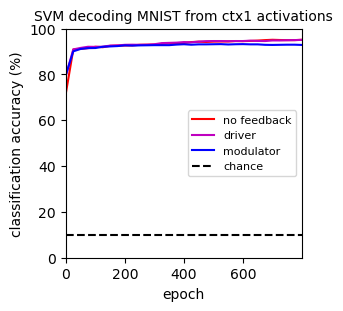

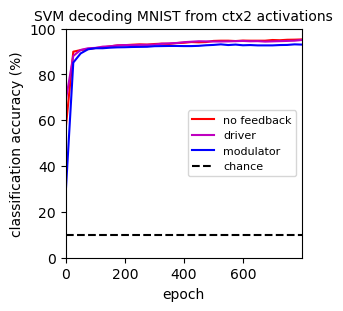

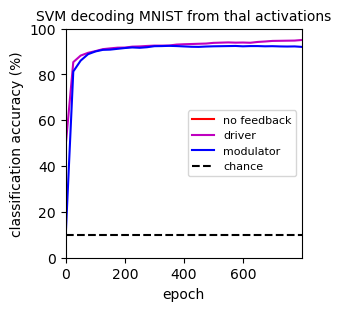

In [17]:
# for layer in accuracies.keys():
#     fig, ax = plt.subplots(1, 1, figsize=(3, 3))
#     for model_idx, model_selected in enumerate(accuracies[layer].keys()):
#         ax.plot(accuracies[layer][model_selected].keys(), np.array(list(accuracies[layer][model_selected].values())) * 100, c=colours[model_idx], label=model_selected)
#     ax.axhline(10, ls="--", c="k", label="chance")
#     ax.set_title(f"SVM decoding MNIST from {layer} activations")
#     ax.set_ylabel("classification accuracy (%)")
#     ax.set_xlabel("epoch")
#     ax.set_ylim(0, 100)
#     ax.set_xlim(list(accuracies[layer][model_selected].keys())[0], list(accuracies[layer][model_selected].keys())[-1])
#     ax.legend(loc="center right")
#     fig.savefig(Path(save_path, f"svm_decoding_{layer}.png"))

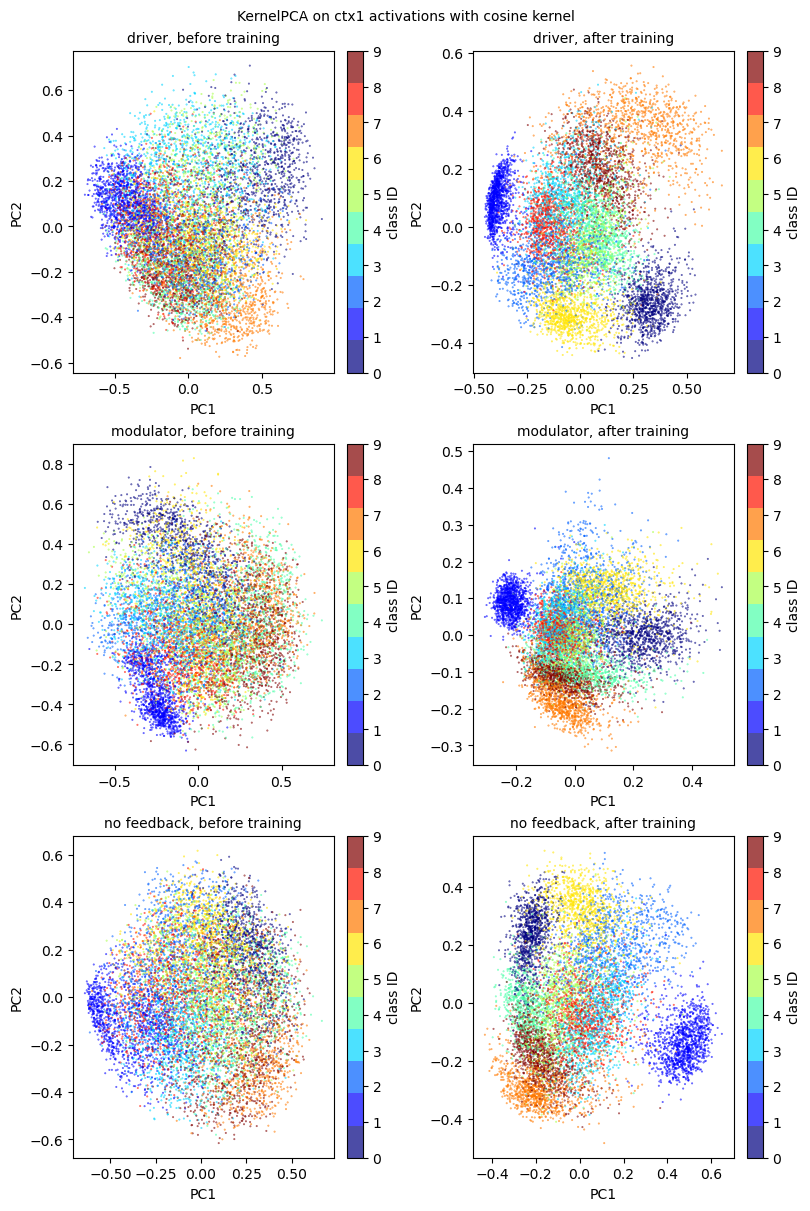

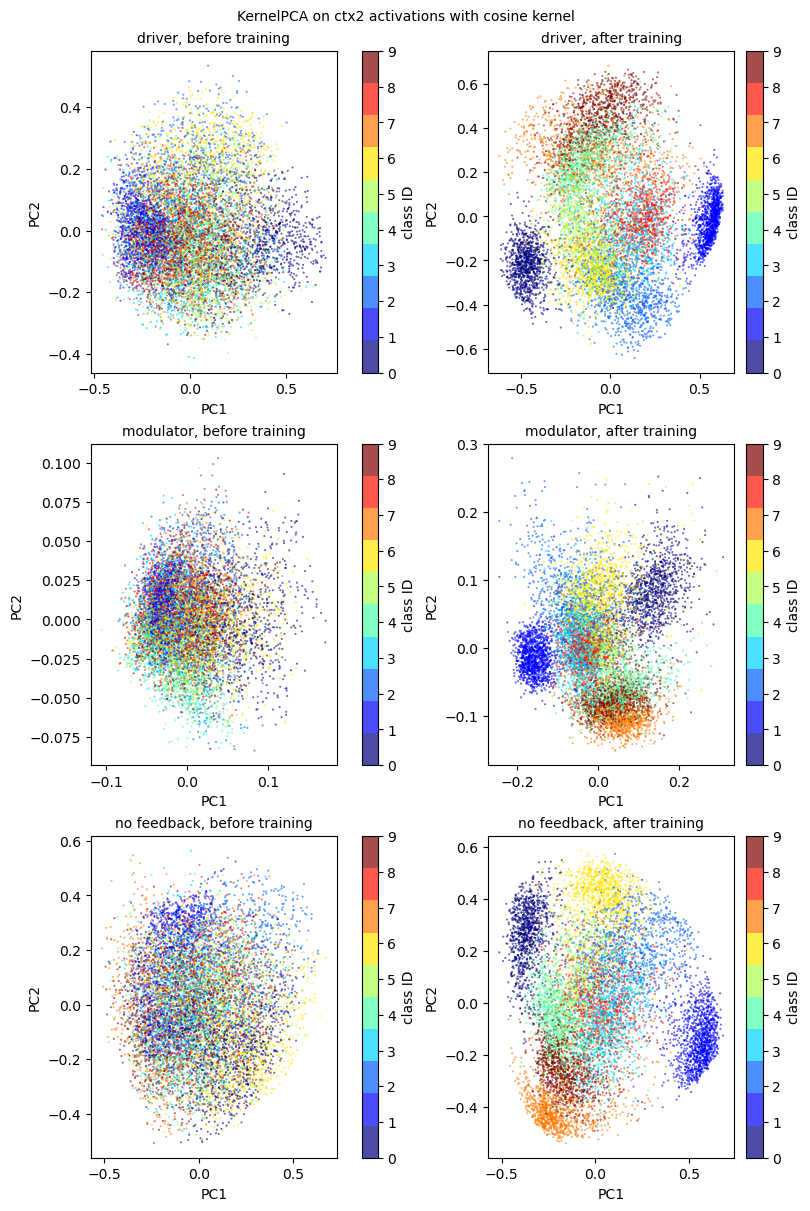

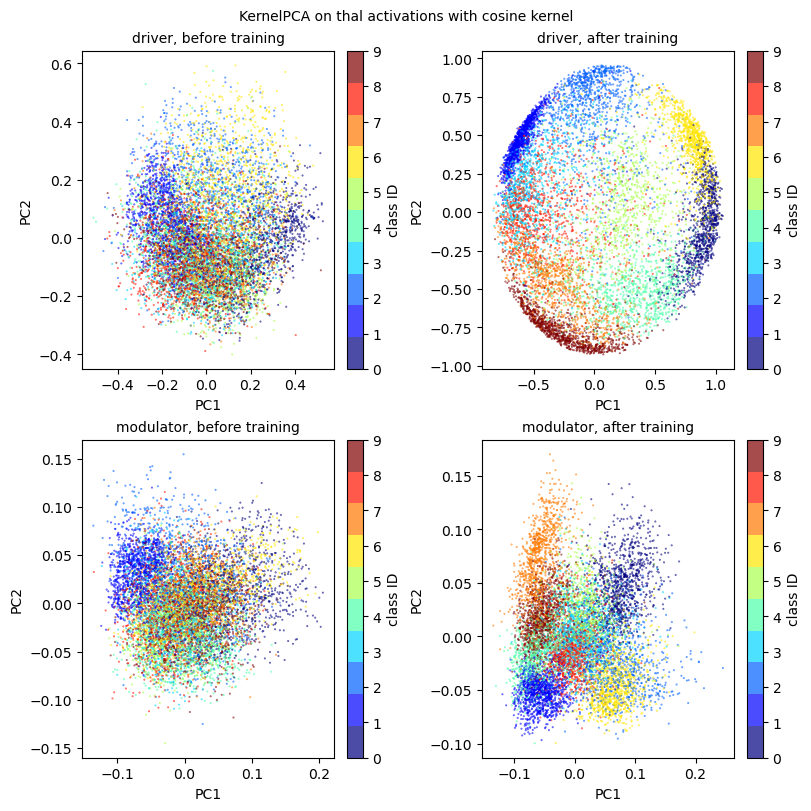

In [18]:
# activations analysis
reduction_method = "KernelPCA"
kernel = "cosine"
epochs = {"before training": 0,
          "after training": 799}

# generate colourmap
jet_cmap = plt.colormaps["jet"]  
N = 10
colors = jet_cmap(np.linspace(0, 1, N)) 
discrete_cmap = mcolors.ListedColormap(colors)

reduced_activations = {}
for layer in accuracies.keys():
    
    reduced_activations= {}
    if layer == "thal":
        model_list = ["driver", "modulator"]
    else:
        model_list = ["driver", "modulator", "no feedback"]

    fig, ax = plt.subplots(len(model_list), len(epochs), figsize=(4 * len(epochs), 4 * len(model_list)), layout="constrained")

    for model_idx, model_selected in enumerate(model_list):

        reduced_activations[model_selected] = {}

        for epoch_idx, (epoch_name, epoch) in enumerate(epochs.items()):
            
            features = activations[model_selected][epoch][list(activations[model_selected][epoch].keys())[readable_layer_idxs[layer]]].detach().numpy()
        
            if reduction_method == "PCA":
                pca = PCA(n_components=2)
                activations_2d = pca.fit_transform(features)
                title = f"{reduction_method} on {layer} activations"
                save_tag = "pca"
            elif reduction_method == "KernelPCA":
                pca_transformer = KernelPCA(n_components=2, kernel=kernel)
                activations_2d = pca_transformer.fit_transform(features)
                title = f"{reduction_method} on {layer} activations with {kernel} kernel"
                save_tag = "kernel_pca"


            scatter = ax[model_idx, epoch_idx].scatter(activations_2d[:, 0], activations_2d[:, 1], c=y_all_reshaped, cmap=discrete_cmap, alpha=0.7, s=0.2)
            plt.colorbar(scatter, label="class ID")
            
            ax[model_idx, epoch_idx].set_title(f"{model_selected}, {epoch_name}")
            ax[model_idx, epoch_idx].set_xlabel("PC1")
            ax[model_idx, epoch_idx].set_ylabel("PC2")

            reduced_activations[model_selected][epoch_name] = activations_2d

    reduced_activations["method"] = reduction_method
    reduced_activations["kernel"] = kernel

    fig.suptitle(title)
    fig.savefig(Path(save_path, f"{save_tag}_{layer}_activations_prepostlearning.png"))

In [ ]:
# save decoding accuracies
with open(Path(save_path, "activations_reduced.pkl"), "wb") as handle:
    pickle.dump(accuracies, handle)

In [ ]:
# # load decoding accuracies if don't want to re-run
# with open(Path(save_path, "activations_reduced.pkl"), "rb") as handle:
#     accuracies = pickle.load(handle)

In [19]:
# define readable names for connections of interest
# NOTE: always double check these before using
readable_weight_idxs = {"input_to_ctx1": {"no feedback": 2,
                                          "driver": 8,
                                          "modulator": 8},
                        "ctx1_to_ctx2": {"no feedback": 4,
                                          "driver": 10,
                                          "modulator": 10},
                        "thal_to_ctx1": {"no feedback": None,
                                          "driver": 2,
                                          "modulator": 2},
                        "thal_to_ctx2": {"no feedback": None,
                                          "driver": 4,
                                          "modulator": 4}}

In [20]:
# # weight decomposition analysis
# weights_selected = ["input_to_ctx1", "ctx1_to_ctx2", "thal_to_ctx1", "thal_to_ctx2"]
# svds = {}
# for weights_select in weights_selected:
#     svds[weights_select] = {}
#     for model_selected in models_selected:
#         svds[weights_select][model_selected] = {}
#         for epoch in epochs_range:

#             if (model_selected == "no feedback") and (weights_select in ["thal_to_ctx1", "thal_to_ctx2"]):

#                 svds[weights_select][model_selected][epoch] = None

#             else:

#                 # get weights in forward pass direction and compute spectral measures
#                 weights = results[model_selected]["state_dicts"][epoch][list(results[model_selected]["state_dicts"][epoch].keys())[readable_weight_idxs[weights_select][model_selected]]]

#                 # SVD on weights
#                 U, s, Vh = svd(weights)
#                 s_norm = s / np.sum(s)
                
#                 # compute spectral metrics
#                 spectral_entropy = entropy(s_norm)
#                 spectral_norm = np.max(s)
#                 condition_number = np.max(s) / np.min(s)
                
#                 # store
#                 svds[weights_select][model_selected][epoch] = {"U": U,
#                                                             "s": s,
#                                                             "Vh": Vh,
#                                                             "s_norm": s_norm,
#                                                             "spectral_entropy": spectral_entropy,
#                                                             "spectral_norm": spectral_norm,
#                                                             "condition_number": condition_number}

#                 # print(f"{weights.shape=}")
#                 # print(f"{Vh.shape=}")

In [21]:
# weights_select = "thal_to_ctx1"
# model_select = "driver"
# epochs = [0, 799]

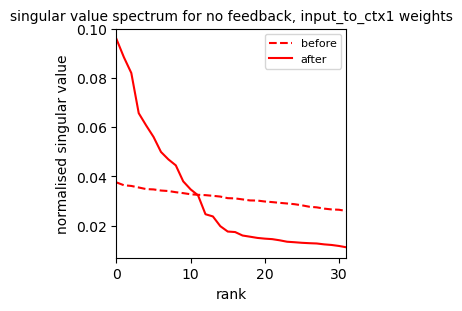

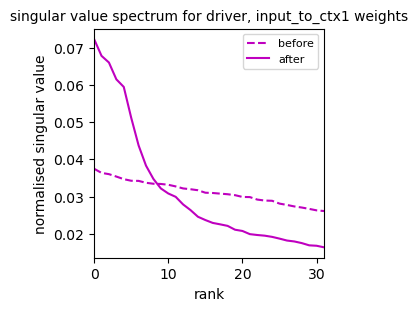

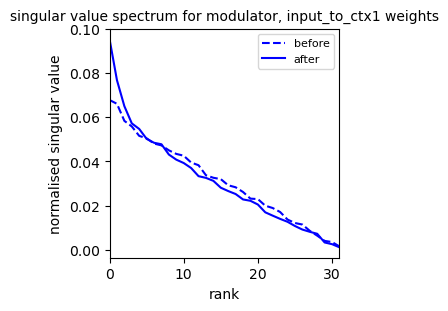

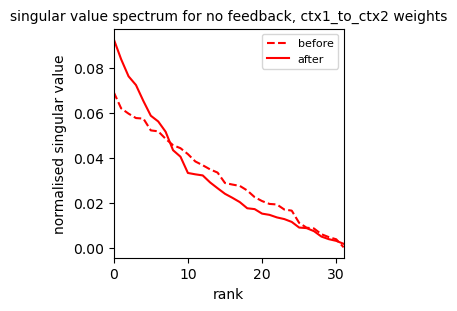

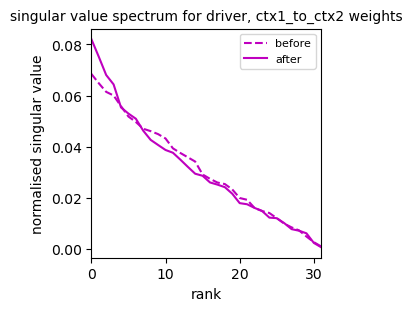

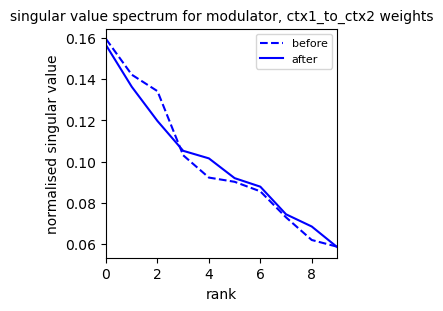

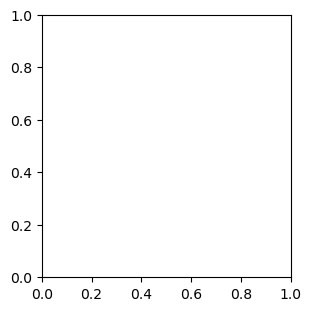

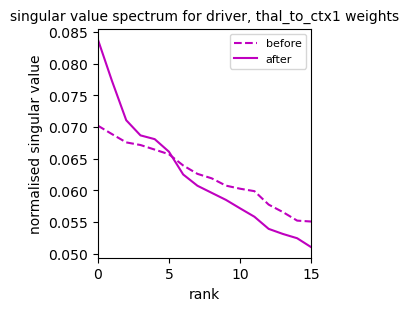

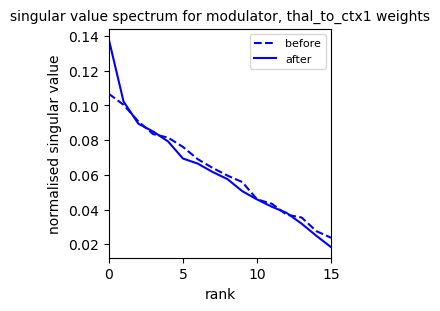

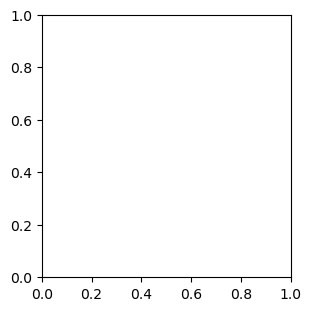

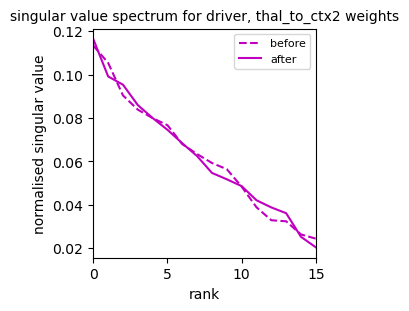

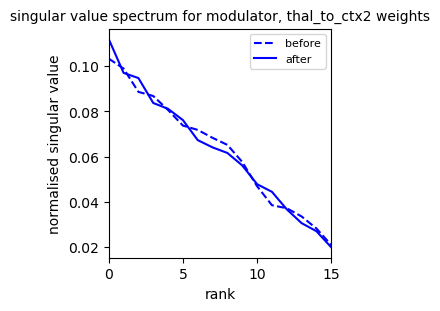

In [22]:
# for weights_select in weights_selected:
#     for model_idx, model_select in enumerate(models_selected):
#         try:
#             fig, ax = plt.subplots(1, 1, figsize=(3, 3))
#             epochs = {"before": 0,
#                     "after": 799}
#             c = colours[model_idx]
#             linestyles = ["--", "-"]
#             for epoch_idx, (epoch_name, epoch) in enumerate(epochs.items()):
#                 ax.plot(svds[weights_select][model_select][epoch]["s_norm"], c=c, label=epoch_name, ls=linestyles[epoch_idx])
#             ax.set_title(f"singular value spectrum for {model_select}, {weights_select} weights")
#             ax.set_ylabel("normalised singular value")
#             ax.set_xlabel("rank")
#             ax.set_xlim(0, len(svds[weights_select][model_select][epoch]["s_norm"])-1)
#             ax.legend()
#             fig.savefig(Path(save_path, f"sv_spectrum_{model_select}_{weights_select}_prepostlearning.png"))
#         except:
#             pass

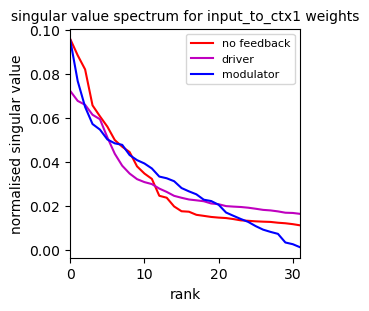

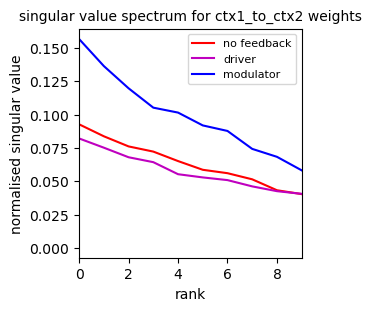

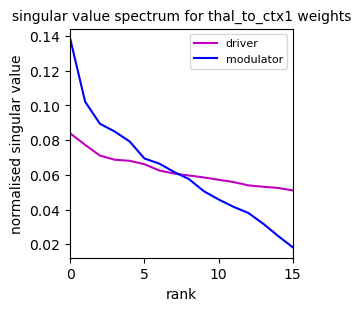

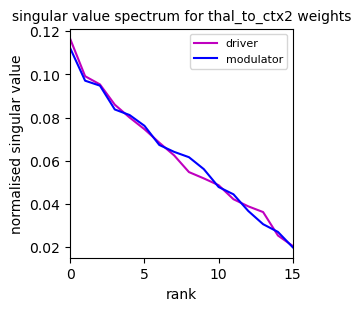

In [23]:
# for weights_select in weights_selected:
#     fig, ax = plt.subplots(1, 1, figsize=(3, 3))
#     for model_idx, model_select in enumerate(models_selected):
#         try:
#             ax.plot(svds[weights_select][model_select][epoch]["s_norm"], c=colours[model_idx], label=model_select)
#             ax.set_title(f"singular value spectrum for {weights_select} weights")
#             ax.set_ylabel("normalised singular value")
#             ax.set_xlabel("rank")
#             ax.set_xlim(0, len(svds[weights_select][model_select][epoch]["s_norm"])-1)
#         except:
#             pass
#     ax.legend(loc="upper right")
#     fig.savefig(Path(save_path, f"norm_sv_spectrum_{model_select}_{weights_select}.png"))

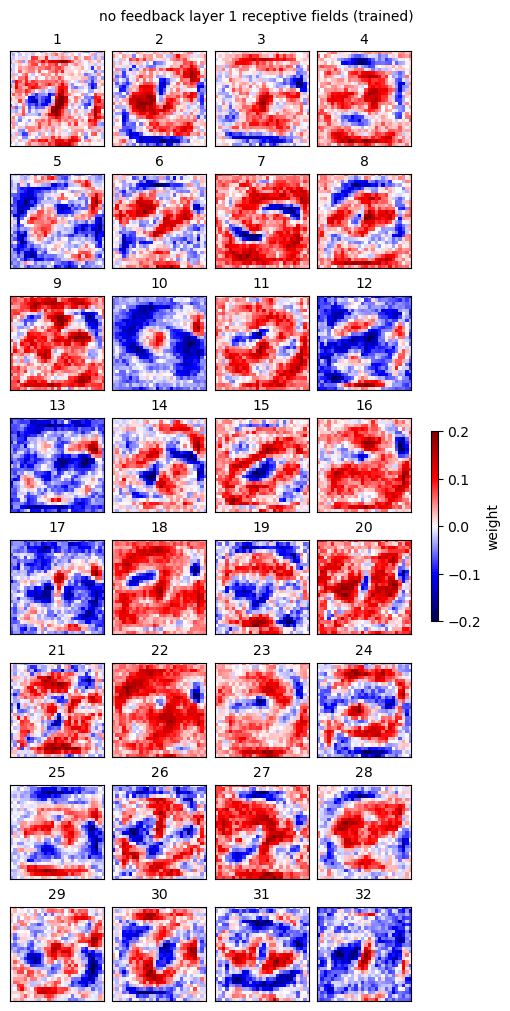

In [26]:
# model_selected = "no feedback"
# # receptive field analysis
# cmap = cm.get_cmap("seismic")
# clims = [-0.2, 0.2]
# epoch_name = "trained"
# epoch = 799
# fig, ax = plt.subplots(8, 4, figsize=(5, 10), layout="constrained")

# for neuron_id in range(32):

#     row_idx = neuron_id // 4
#     col_idx = neuron_id % 4

#     input_layer_weights = results[model_selected]["state_dicts"][epoch][list(results[model_selected]["state_dicts"][epoch].keys())[readable_weight_idxs["input_to_ctx1"][model_selected]]]


#     weights_this_neuron = get_neuron_weights(weights=input_layer_weights,
#                                              neuron_id=neuron_id,
#                                              shape=(28, 28))
#     plot_receptive_field(weights=weights_this_neuron,
#                          ax=ax[row_idx, col_idx],
#                          cmap=cmap,
#                          clims=clims,
#                          title=neuron_id+1)

# psm = ax[0, 0].pcolormesh(weights_this_neuron, cmap=cmap, rasterized=True, vmin=clims[0], vmax=clims[1])
# cbar = fig.colorbar(psm, ax=ax, shrink=0.2, aspect=30)
# cbar.set_label("weight")
# cbar.ax.xaxis.set_ticks_position('top') 
# cbar.ax.xaxis.set_label_position('top')
# fig.suptitle(f"{model_selected} layer 1 receptive fields ({epoch_name})")
# fig.savefig(Path(save_path, f"norm_sv_spectrum_{model_select}_{weights_select}.png"))

### **Ablation analysis**

In [24]:
# accuracy with ablated feedback connections
epoch = 799
activations = {}
accuracies = {}
weights_status_dict = {"full": [],
                       "thal_to_ctx1 ablated": ["thal_to_ctx1"],
                       "thal_to_ctx2 ablated": ["thal_to_ctx2"],
                       "all feedback ablated": ["thal_to_ctx1", "thal_to_ctx2"]}
for ablated, weights_to_zero_list in weights_status_dict.items():
    activations[ablated] = {}
    accuracies[ablated] = {}
    for model_selected in models_selected:
        activations[ablated][model_selected] = {}
        accuracies[ablated][model_selected] = {}

        # instantiate model
        model = CTCNet(input_size=results[model_selected]["hyperparams"]["input_size"],
                        output_size=results[model_selected]["hyperparams"]["output_size"],
                        ctx_layer_size=results[model_selected]["hyperparams"]["ctx_layer_size"],
                        thal_layer_size=results[model_selected]["hyperparams"]["thal_layer_size"],
                        thalamocortical_type=results[model_selected]["hyperparams"]["thalamocortical_type"],
                        thal_reciprocal=results[model_selected]["hyperparams"]["thal_reciprocal"],
                        thal_to_readout=results[model_selected]["hyperparams"]["thal_to_readout"], 
                        thal_per_layer=results[model_selected]["hyperparams"]["thal_per_layer"])

        # get model trained to specified epoch
        weights = copy.deepcopy(results[model_selected]["state_dicts"][epoch])

        # set chosen weights to zero
        for weights_to_zero in weights_to_zero_list:
            try:
                weights_idx = readable_weight_idxs[weights_to_zero][model_selected]
                weights_name = list(weights.keys())[weights_idx]
                selected_weights_shape = weights[weights_name].shape
                new_weights = torch.zeros(selected_weights_shape)
                weights[weights_name] = new_weights
            except Exception as e:
                print(f"Failed at setting weights to zero for {model_selected} with exception: {e}")
                traceback.print_exception(e)

        # set model weights
        model.load_state_dict(weights)

        # do inference on test set
        # register hooks for specific layers
        hook_handles = []
        activations_this_epoch = {}
        for name, layer in model.named_modules():
            handle = layer.register_forward_hook(lambda module, input, output: activation_hook(module, input, output, activations_this_epoch))
            hook_handles.append(handle)
        
        # inference (on full dataset)
        with torch.no_grad():
            
            y_est_logits = model(torch.Tensor(X_all_reshaped))
            y_est_prob = softmax(y_est_logits.detach().numpy())
            y_est = np.argmax(y_est_prob, axis=1)

            # Remove hooks after use
            for handle in hook_handles:
                handle.remove()
        
        # compute classification accuracy
        correct = 0
        for samp_idx in range(y_est.shape[0]):
            if y_est[samp_idx] == y_all_reshaped[samp_idx]:
                correct += 1
        accuracy = correct / y_est.shape[0]
        print(f"accuracy: {accuracy * 100:.2f}%")

        activations[ablated][model_selected][epoch] = copy.deepcopy(activations_this_epoch)
        accuracies[ablated][model_selected][epoch] = accuracy


accuracy: 93.85%
accuracy: 94.59%
accuracy: 92.72%
Failed at setting weights to zero for no feedback with exception: list indices must be integers or slices, not NoneType
accuracy: 93.85%
accuracy: 48.63%
accuracy: 44.67%
Failed at setting weights to zero for no feedback with exception: list indices must be integers or slices, not NoneType
accuracy: 93.85%


Traceback (most recent call last):
  File "/var/folders/4g/1kv65jgx1x1558h12tz57s580000gn/T/ipykernel_62812/3784880362.py", line 33, in <module>
    weights_name = list(weights.keys())[weights_idx]
TypeError: list indices must be integers or slices, not NoneType
Traceback (most recent call last):
  File "/var/folders/4g/1kv65jgx1x1558h12tz57s580000gn/T/ipykernel_62812/3784880362.py", line 33, in <module>
    weights_name = list(weights.keys())[weights_idx]
TypeError: list indices must be integers or slices, not NoneType


accuracy: 91.87%
accuracy: 33.06%
Failed at setting weights to zero for no feedback with exception: list indices must be integers or slices, not NoneType
Failed at setting weights to zero for no feedback with exception: list indices must be integers or slices, not NoneType
accuracy: 93.85%
accuracy: 47.68%
accuracy: 11.45%


Traceback (most recent call last):
  File "/var/folders/4g/1kv65jgx1x1558h12tz57s580000gn/T/ipykernel_62812/3784880362.py", line 33, in <module>
    weights_name = list(weights.keys())[weights_idx]
TypeError: list indices must be integers or slices, not NoneType
Traceback (most recent call last):
  File "/var/folders/4g/1kv65jgx1x1558h12tz57s580000gn/T/ipykernel_62812/3784880362.py", line 33, in <module>
    weights_name = list(weights.keys())[weights_idx]
TypeError: list indices must be integers or slices, not NoneType


In [ ]:
# save ablation activations
with open(Path(save_path, "ablation_activations.pkl"), "wb") as handle:
    pickle.dump(activations, handle)

In [ ]:
# save ablation accuracies
with open(Path(save_path, "ablation_accuracies.pkl"), "wb") as handle:
    pickle.dump(accuracies, handle)

In [ ]:
# # load ablation activations
# with open(Path(save_path, "ablation_activations.pkl"), "rb") as handle:
#     activations = pickle.load(handle)

In [ ]:
# # load ablation accuracies
# with open(Path(save_path, "ablation_accuracies.pkl"), "rb") as handle:
#     accuracies = pickle.load(handle)

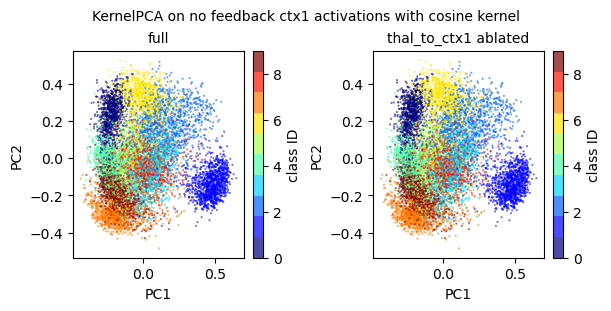

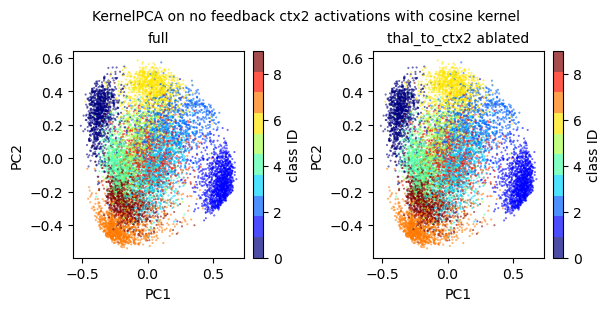

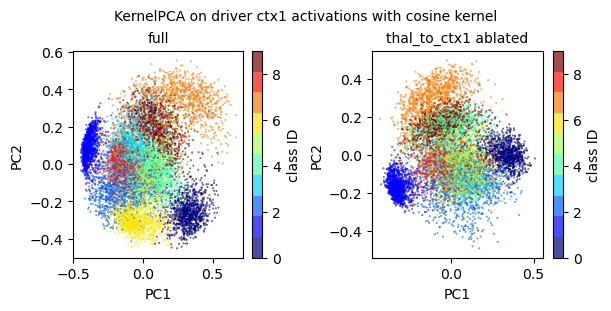

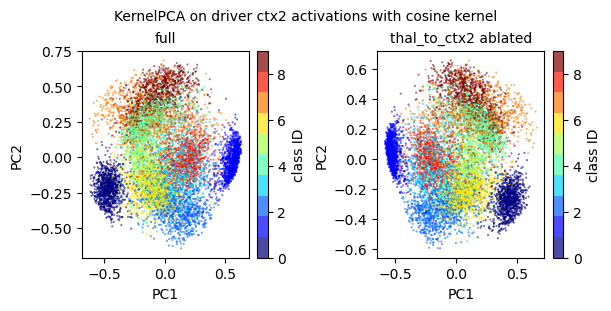

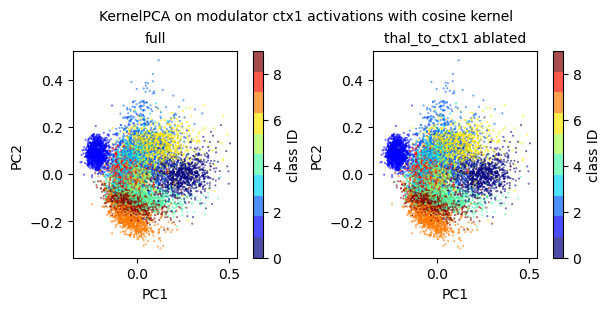

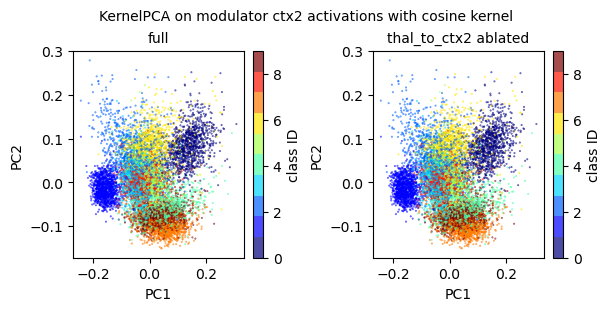

In [26]:
# # activations with ablated feedback
# reduction_method = "KernelPCA"
# kernel = "cosine"
# epochs = [0, 775]
# # generate colourmap
# jet_cmap = plt.colormaps["jet"]  
# N = 10
# colors = jet_cmap(np.linspace(0, 1, N)) 
# discrete_cmap = mcolors.ListedColormap(colors)
# layers = ["ctx1", "ctx2"]
# for model_selected in models_selected:
#     for layer in layers:
#         if layer == "ctx1":
#             weights_dict_use = copy.deepcopy(weights_status_dict)
#             del weights_dict_use["thal_to_ctx2 ablated"]
#             del weights_dict_use["all feedback ablated"]
#         elif layer == "ctx2":
#             weights_dict_use = copy.deepcopy(weights_status_dict)
#             del weights_dict_use["thal_to_ctx1 ablated"]
#             del weights_dict_use["all feedback ablated"]
#         fig, ax = plt.subplots(1, len(weights_dict_use), figsize=(6, 3))
#         for ablation_idx, (ablated, weights_to_zero_list) in enumerate(weights_dict_use.items()):
#             try:

#                 # features = activations[ablated][model_selected][epoch][list(activations[ablated][model_selected][epoch].keys())[readable_layer_idxs[layer]]].detach().numpy()
#                 features = activations[ablated][model_selected][epoch][list(activations[ablated][model_selected][epoch].keys())[readable_layer_idxs[layer]]].detach().numpy()

#                 if reduction_method == "PCA":
#                     pca = PCA(n_components=2)
#                     activations_2d = pca.fit_transform(features)
#                     title = f"{reduction_method} on {model_selected} {layer} activations"
#                     save_tag = "pca"
#                 elif reduction_method == "KernelPCA":
#                     pca_transformer = KernelPCA(n_components=2, kernel=kernel)
#                     activations_2d = pca_transformer.fit_transform(features)
#                     title = f"{reduction_method} on {model_selected} {layer} activations with {kernel} kernel"
#                     save_tag = "kernel_pca"

#                 scatter = ax[ablation_idx].scatter(activations_2d[:, 0], activations_2d[:, 1], c=y_all_reshaped, cmap=discrete_cmap, alpha=0.7, s=0.2)
#                 plt.colorbar(scatter, label="class ID")
#                 ax[ablation_idx].set_title(f"{ablated}")
#                 ax[ablation_idx].set_xlabel("PC1")
#                 ax[ablation_idx].set_ylabel("PC2")

#                 fig.suptitle(title)
#                 fig.patch.set_facecolor("w")
#                 fig.savefig(Path(save_path, f"{save_tag}_{model_selected}_{layer}_activations_ablation.png"), dpi=100)
#             except:
#                 pass

In [28]:
models = ["no feedback", "driver", "modulator"]
accuracies_reformat = {kind: [v[799] for _, v in accuracies[kind].items()] for kind in accuracies.keys()}
accuracies_reformat["thal_to_ctx1 ablated"][0] = None
accuracies_reformat["thal_to_ctx2 ablated"][0] = None
accuracies_reformat["all feedback ablated"][0] = None

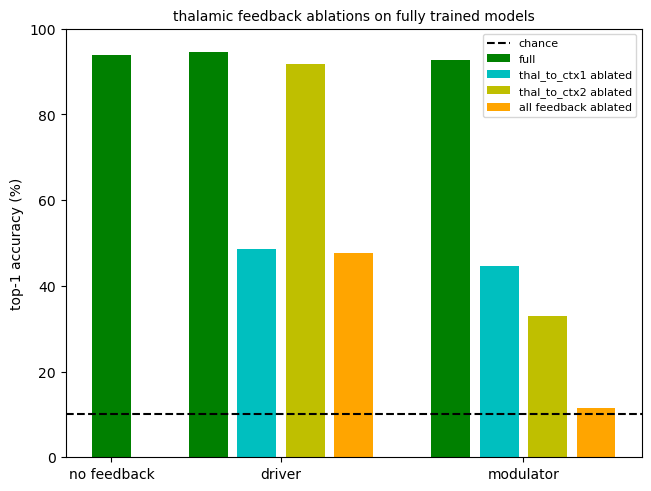

In [30]:
# # bar plot of accuracy for ablated models
# colours = ["g", "c", "y", "orange"]
# fig, ax = plt.subplots(1, 1)
# ax.axhline(10, ls="--", c="k", label="chance")
# x = 0
# offset = 0
# tick_locs = []
# x_group = 0
# for model_idx, model in enumerate(models):
#     x_group +=  offset
#     num_bars = 0
#     for ablation_idx, (ablation_type, accuracies_) in enumerate(accuracies_reformat.items()):
#         x = x_group + ablation_idx
#         if accuracies_[model_idx] is not None:
#             num_bars += 1
#             if model == "driver":
#                 label = ablation_type
#             else:
#                 label=None
#             ax.bar(x, accuracies_[model_idx] * 100, facecolor=colours[ablation_idx], label=label)
#             offset = 5
#         else:
#             offset = 2
#     tick_locs.append(x_group+num_bars/2 -.5)
# ax.legend()
# ax.set_ylim(0, 100)
# ax.set_xticks(tick_locs, models)
# ax.set_ylabel("top-1 accuracy (%)")
# ax.set_title(f"thalamic feedback ablations on fully trained models")
# fig.savefig(Path(save_path, f"accuracy_ablation.png"))

In [ ]:
# driver - conns to ctx1 more important than ctx2 (ctx2 doesnt contribute)
# modulator - conns to ctx2 more important than ctx1 (both contribute)
# this is at odds with Mo & Sherman but we do not have both driver and modulator conns so this could be why